In [1]:
library(tidyverse)
library(networkD3)
library(htmlwidgets)
library(webshot)
library(RColorBrewer)
library(ggrepel)
library(ggthemes)
library(cowplot)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘htmlwidgets’

The following object is masked from ‘package:networkD3’:

    JS


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggthemes’:

    theme_map



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- matrisome_list <- paste(dirs$data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")
dset_idx <- 1

# Functions

In [16]:
to_vplot_df <- function(df, padj_thresh = 0.05, log2_fc_thresh = log2(2)) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue) %>%
        dplyr::mutate(DE = case_when(
            (padj < padj_thresh) & (log2_fc > log2_fc_thresh) ~ "Up",
            (padj < padj_thresh) & (log2_fc < -log2_fc_thresh) ~ "Down",
            TRUE ~ "Not Sig."
        ))
    return(vplot_df)
}


make_vplot <- function(df, add_contour = FALSE, jitter_w = 0, jitter_h = 0, point_size = 0.25, label_text_size = 12, lines = TRUE, hide_legend = TRUE, abs_log2_fc_outlier_thresh = 15, padj_thresh = 1e-10) {
    lfc_outliers_df <- df %>%
        dplyr::filter(abs(log2_fc) > abs_log2_fc_outlier_thresh) %>%
        dplyr::filter(padj < padj_thresh)
    
    plt <- ggplot(data = df) +
        geom_point(aes(y = neg_log10_padj, x = log2_fc, color = DE), size = point_size, position = position_jitter(w = jitter_w, h = jitter_h)) +
        guides(color = guide_legend(override.aes = list(size = 10))) +
        scale_color_manual(name = "DE", values = setNames(c("gray30", "firebrick3", "steelblue3"), c("Not Sig.", "Up", "Down"))) +
        {if (add_contour) geom_density2d(aes(colour=..level..))} +
        {if (add_contour) scale_colour_gradient(low = "#00e600", high="#cc0000", name = "Density")} +
        {if (nrow(lfc_outliers_df) > 0) geom_label_repel(data = lfc_outliers_df, aes(label = gene_ID, y = neg_log10_padj, x = log2_fc), size = 2)} +
        {if (lines) geom_hline(yintercept = -log10(0.05), color = "gray25", size = 0.5) } +
        {if (lines) geom_vline(xintercept = log2(2), color = "gray25", size = 0.5) } +
        {if (lines) geom_vline(xintercept = -log2(2), color = "gray25", size = 0.5) } +
        xlab("log2 fold-change") +
        ylab("-log10(adj. p-val)") +
        theme_classic() +
        theme(
            text = element_text(size = label_text_size),
            legend.title = element_blank(),
            legend.background = element_blank(),
            legend.key = element_rect(fill = NA, color = NA),
            legend.position = "bottom"
        ) +
        guides(alpha="none")

    return(plt)
}

# Load data

In [4]:
matrisome_summary_df <- read_tsv(paste0(dirs$analysis_dir, "/", dsets[dset_idx], "_matrisome_summary.tsv"))
dge_res_df <- read_tsv(paste0(dirs$analysis_dir, "/", dsets[dset_idx], "_DESeq_results.tsv"))

Parsed with column specification:
cols(
  geneID = col_character(),
  in_unified_dataset = col_logical(),
  lowly_expressed = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)


# Volcano plots

Saving 6.67 x 6.67 in image


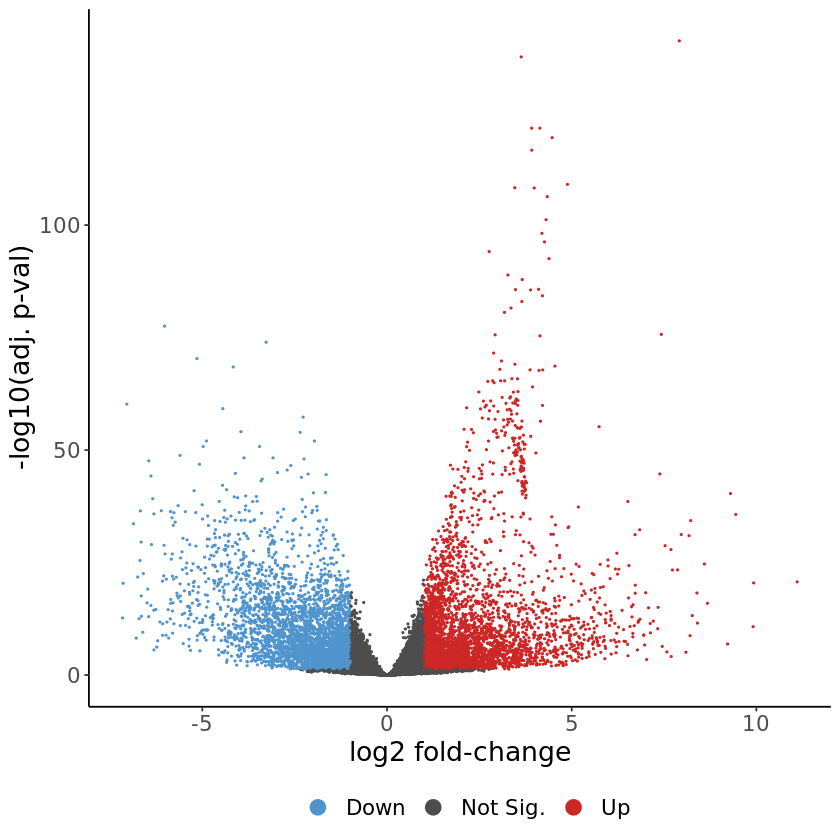

In [5]:
dge_res_df %>%
    to_vplot_df() %>%
    make_vplot(label_text_size = 16, lines = FALSE)
ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_all_genes_vplot.png"), last_plot())

Warning message:
“Removed 110 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 110 rows containing missing values (geom_point).”

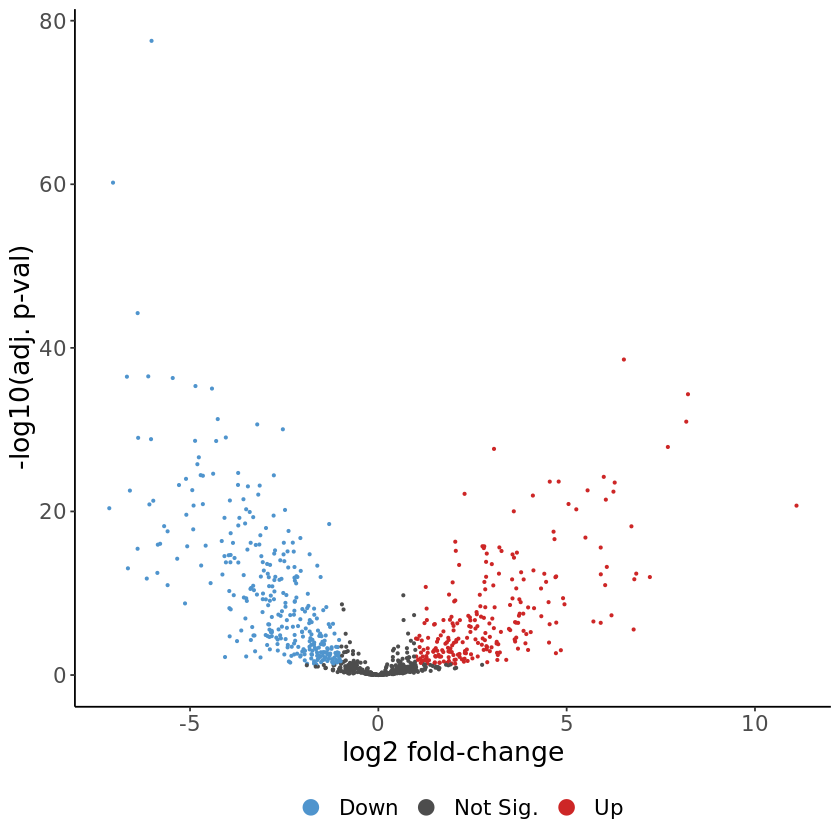

In [6]:
matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot(point_size = 0.5, label_text_size = 16, lines = FALSE)
ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_matrisome_genes_vplot.png"), last_plot())

Warning message:
“Removed 110 rows containing missing values (geom_point).”

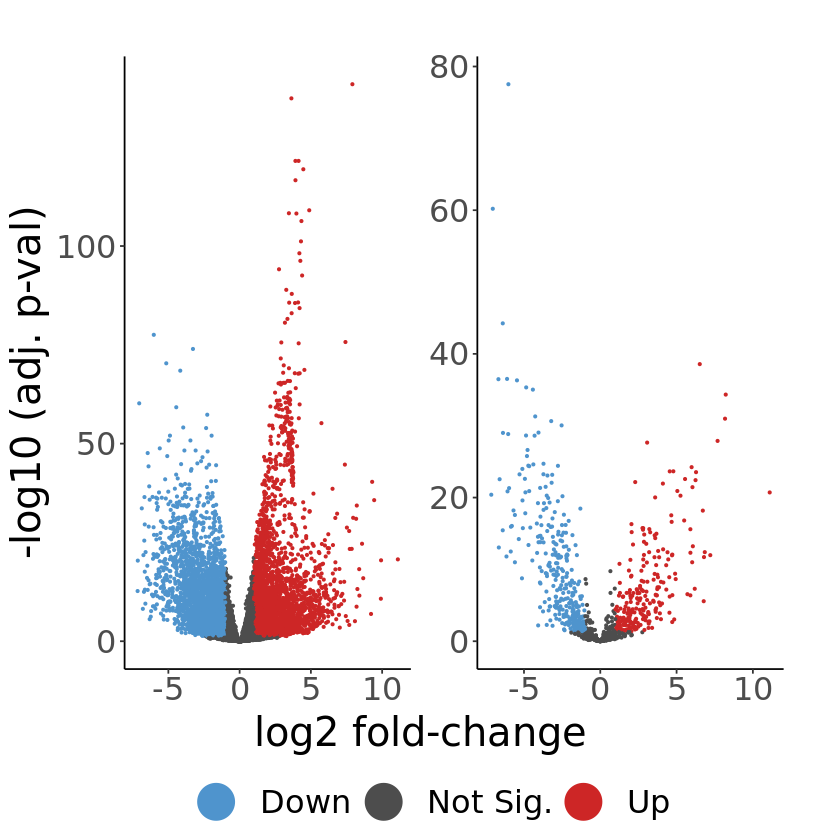

In [17]:
p1 <- dge_res_df %>%
    to_vplot_df() %>%
    make_vplot(point_size = 0.5, label_text_size = 24, lines = FALSE)
p2 <- matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot(point_size = 0.5, label_text_size = 24, lines = FALSE)
pg1 <- plot_grid(
    p1 + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
    p2 + theme(legend.position = "none", axis.title.x = element_blank(), axis.title.y = element_blank()),
#     labels = c("A", "B"),
#     label_size = 16,
    vjust = -1
    ) +
    theme(plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    draw_label("log2 fold-change", size = 24, x = 0.5, y = 0, vjust = 1, angle = 0) +
    draw_label("-log10 (adj. p-val)", size = 24, x = 0, y = 0.5, vjust = -0.25, angle = 90)
# pg1
# ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_combined_vplots.png"), last_plot())
pg2 <- plot_grid(
    pg1,
    get_legend(p1),
    nrow = 2,
    rel_heights = c(3, 0.3)
)
pg2
ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_combined_vplots.png"), last_plot(), height = 6, width = 12)
# ggsave(paste0(dirs$figures_dir, "/", dsets[dset_idx], "_combined_vplots.png"), last_plot())

# Sankey diagram

In [8]:
sd_df <- matrisome_summary_df %>%
#     mutate(gene_list = rep("Matrisome Genes in Dataset", nrow(matrisome_summary_df))) %>%
    mutate(gene_list = ifelse(in_unified_dataset, "Matrisome Genes in Dataset", "Non-Matrisome Genes/Not in Dataset")) %>%
    mutate(DEG_cat = ifelse((padj < 0.05 & abs(log2FoldChange) > log2(2) & !lowly_expressed), "Sig. DEGs", "Non-sig. DEGs/Lowly Expressed")) %>%
    dplyr::select(gene_list, DEG_cat, category)

head(sd_df)

gene_list,DEG_cat,category
<chr>,<chr>,<chr>
Matrisome Genes in Dataset,Sig. DEGs,ECM Glycoproteins
Matrisome Genes in Dataset,Non-sig. DEGs/Lowly Expressed,ECM Glycoproteins
Matrisome Genes in Dataset,Sig. DEGs,ECM Glycoproteins
Matrisome Genes in Dataset,Sig. DEGs,ECM Glycoproteins
Matrisome Genes in Dataset,Non-sig. DEGs/Lowly Expressed,ECM Glycoproteins
Matrisome Genes in Dataset,Non-sig. DEGs/Lowly Expressed,ECM Glycoproteins


In [9]:
source_v = c()
target_v = c()
value_v = c()

# gene list -> DEG cat
sd1_df <- sd_df %>%
    group_by(gene_list, DEG_cat) %>%
    dplyr::filter(gene_list == "Matrisome Genes in Dataset") %>%
    summarize(n = n()) %>%
#     mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n[gene_list == "Matrisome Genes in Dataset"]))) %>%
    mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n))) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", n))
sd1_df

source_v <- c(source_v, sd1_df$gene_list_with_n)
target_v <- c(target_v, sd1_df$DEG_cat_with_n)
value_v <- c(value_v, sd1_df$n)



# DEG cat -> category
sd2_df <- sd_df %>%
    mutate(category = replace(category, category == "ECM Glycoproteins", "Glycoproteins (ECM)")) %>%
    mutate(category = replace(category, category == "ECM Regulators", "Regulators (ECM)")) %>%
    group_by(DEG_cat, category) %>%
    dplyr::filter(DEG_cat == "Sig. DEGs") %>%
    summarize(n = n()) %>%
#     mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", sum(n[DEG_cat == "Sig. DEGs"]))) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", sum(n))) %>%
    mutate(category_with_n = paste0(category, ": ", n))
    
sd2_df

source_v <- c(source_v, sd2_df$DEG_cat_with_n)
target_v <- c(target_v, sd2_df$category_with_n)
value_v <- c(value_v, sd2_df$n)

`summarise()` regrouping output by 'gene_list' (override with `.groups` argument)


gene_list,DEG_cat,n,gene_list_with_n,DEG_cat_with_n
<chr>,<chr>,<int>,<chr>,<chr>
Matrisome Genes in Dataset,Non-sig. DEGs/Lowly Expressed,449,Matrisome Genes in Dataset: 1008,Non-sig. DEGs/Lowly Expressed: 449
Matrisome Genes in Dataset,Sig. DEGs,559,Matrisome Genes in Dataset: 1008,Sig. DEGs: 559


`summarise()` regrouping output by 'DEG_cat' (override with `.groups` argument)


DEG_cat,category,n,DEG_cat_with_n,category_with_n
<chr>,<chr>,<int>,<chr>,<chr>
Sig. DEGs,Collagens,28,Sig. DEGs: 559,Collagens: 28
Sig. DEGs,ECM-affiliated Proteins,90,Sig. DEGs: 559,ECM-affiliated Proteins: 90
Sig. DEGs,Glycoproteins (ECM),113,Sig. DEGs: 559,Glycoproteins (ECM): 113
Sig. DEGs,Proteoglycans,24,Sig. DEGs: 559,Proteoglycans: 24
Sig. DEGs,Regulators (ECM),123,Sig. DEGs: 559,Regulators (ECM): 123
Sig. DEGs,Secreted Factors,181,Sig. DEGs: 559,Secreted Factors: 181


In [10]:
links_df <- tibble(
    source = source_v,
    target = target_v,
    value = value_v,
)

nodes_df <- tibble(
    name = c(links_df$source, links_df$target) %>% unique()
)

links_df$sourceID <- match(links_df$source, nodes_df$name) - 1
links_df$targetID <- match(links_df$target, nodes_df$name) - 1

In [11]:
sn <- sankeyNetwork(
    Links = links_df,
    Nodes = nodes_df,
    Source = "sourceID",
    Target = "targetID",
    Value = "value",
    NodeID = "name",
    fontSize = 46,
    fontFamily = "calibri",
    sinksRight=FALSE
)

Links is a tbl_df. Converting to a plain data frame.
Nodes is a tbl_df. Converting to a plain data frame.


In [12]:
sn
saveNetwork(sn, paste0(dirs$figures_dir, "/", dsets[dset_idx], "_matrisome_sankey_diagram.html"))

HTML widgets cannot be represented in plain text (need html)